In [1]:
import numpy as np  
import scipy.signal as signal
import re

import matplotlib.pyplot as plt
from scipy.signal import find_peaks

from rtlsdr import RtlSdr  
sdr = RtlSdr()

In [2]:
F_station = int(433.42e6)   # 433 MHz device
F_offset = 250000         # Offset to capture at  
# We capture at an offset to avoid DC spike
Fc = F_station - F_offset # Capture center frequency  
Fs = int(1000000)         # Sample rate  
N = int(8192000)            # Samples to capture  

# configure device
sdr.sample_rate = Fs      # Hz  
sdr.center_freq = Fc      # Hz  
sdr.gain = 'auto'

# Read samples
samples = sdr.read_samples(N)

# Clean up the SDR device
sdr.close()  
del(sdr)

# Convert samples to a numpy array
x1 = np.array(samples).astype("complex64")

np.savez('transmission', x1=x1)

In [90]:
# data = np.load('rtransmission.npz')
# x1 = data['x1']

(-500000.0, 500000.0)

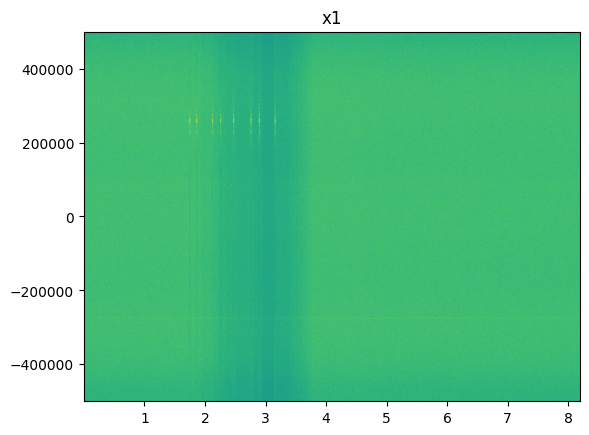

In [3]:
plt.specgram(x1, NFFT=2048, Fs=Fs)  
plt.title("x1")  
plt.ylim(-Fs/2, Fs/2) 

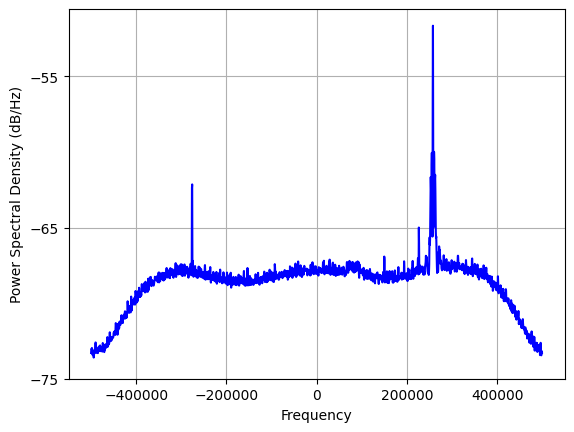

In [4]:
pxx_, freqs_, = plt.psd(x1, NFFT=2048, Fs=Fs, color="blue")  
plt.ticklabel_format(style='plain', axis='y' )  

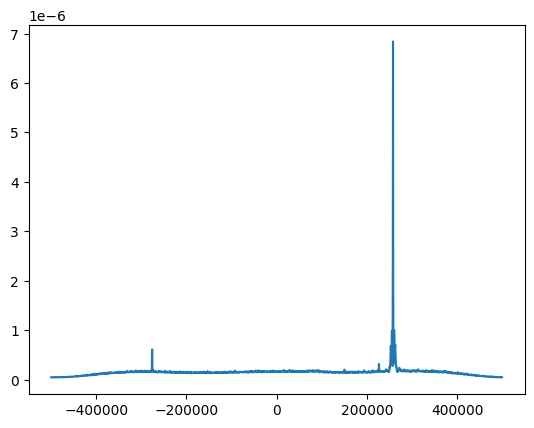

In [5]:
plt.plot(freqs_, pxx_)

In [6]:
pks, _ = find_peaks(pxx_, height=5e-6)
print(pks)
F_offset_new = freqs_[pks][0]
print(F_offset_new)

[1552]
257812.5


In [7]:
# To mix the data down, generate a digital complex exponential 
# (with the same length as x1) with phase -F_offset/Fs
fc1 = np.exp(-1.0j*2.0*np.pi* F_offset_new/Fs*np.arange(len(x1)))  
# Now, just multiply x1 and the digital complex expontential
x2 = x1 * fc1  

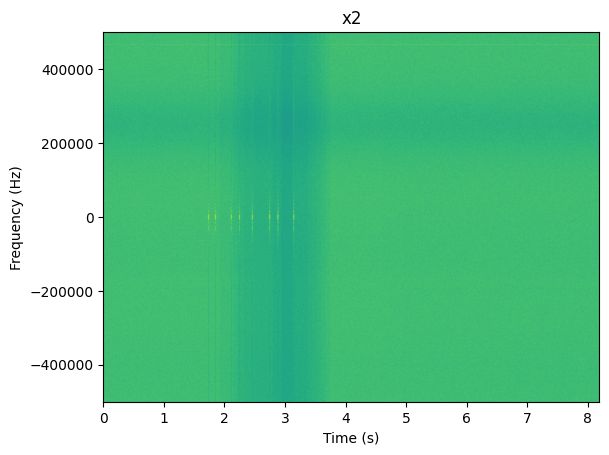

In [8]:
plt.specgram(x2, NFFT=2048, Fs=Fs)  
plt.title("x2")  
plt.xlabel("Time (s)")  
plt.ylabel("Frequency (Hz)")  
plt.ylim(-Fs/2, Fs/2)  
plt.xlim(0,len(x2)/Fs)  
plt.ticklabel_format(style='plain', axis='y' ) 

In [190]:
# An FM broadcast signal has  a bandwidth of 200 kHz
f_bw = 1e3  
n_taps = 64  
# Use Remez algorithm to design filter coefficients
lpf = signal.remez(n_taps, [0, f_bw, f_bw+(Fs/2-f_bw)/4, Fs/2], [1,0], Hz=Fs)  
x3 = signal.lfilter(lpf, 1.0, x2)

# dec_rate = int(Fs / f_bw)
dec_rate = 10
x4 = x3[0::dec_rate]  
# Calculate the new sampling rate
Fs_y = Fs/dec_rate  

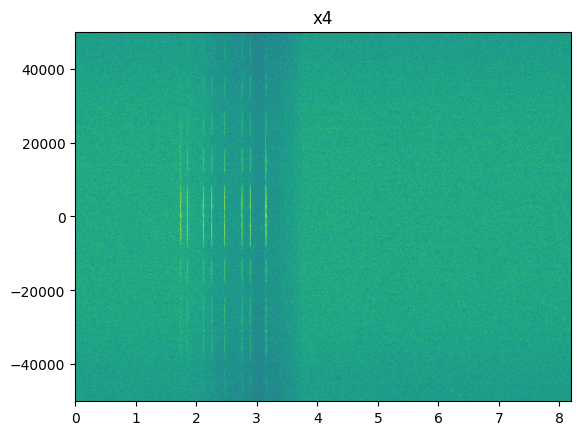

In [191]:
plt.specgram(x4, NFFT=2048, Fs=Fs_y)  
plt.title("x4")  
plt.ylim(-Fs_y/2, Fs_y/2)  
plt.xlim(0,len(x4)/Fs_y)  
plt.ticklabel_format(style='plain', axis='y' )  

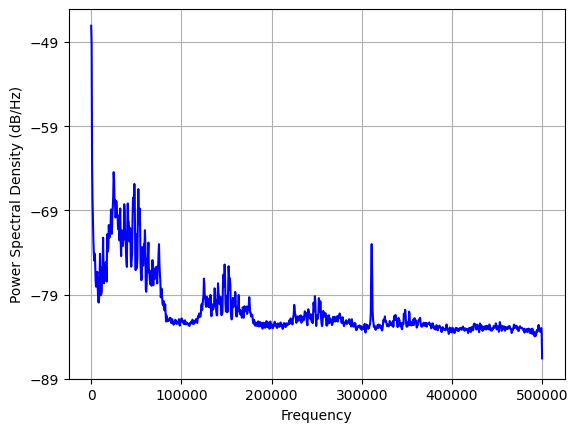

In [192]:
x5 = np.abs(x4)
plt.psd(x5, NFFT=2048, Fs=Fs, color="blue")  
plt.ticklabel_format(style='plain', axis='y' )  

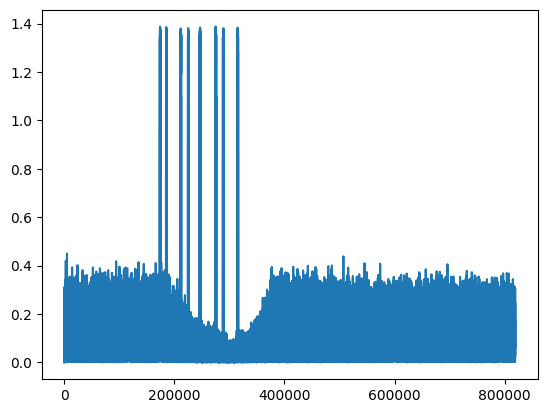

In [193]:
plt.plot(x5)

In [194]:
data = x5

# "calculate" noise level from begining of a file
noise = max(data[0:10000])
print(noise)

0.44953363977625715


In [195]:
# create median vector
median = signal.medfilt(data)

In [196]:
# every signal above will be set to 1, every below to 0
# use additional noise floor
normalized = np.where(median > np.mean(median) + noise, 1, 0)

In [197]:
# trim trailing and leading zeros
normalized_no_zeros = np.trim_zeros(normalized)

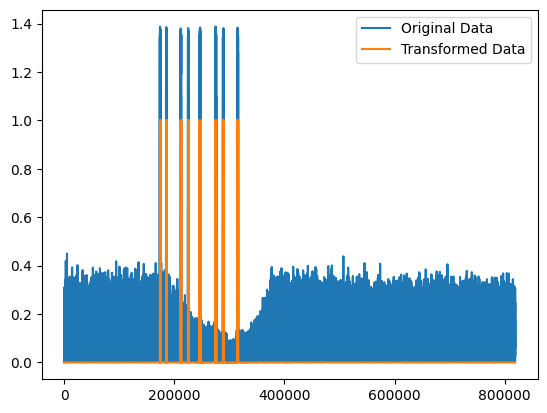

In [198]:
plt.plot(data, label='Original Data')
plt.plot(normalized, label='Transformed Data')
plt.legend()

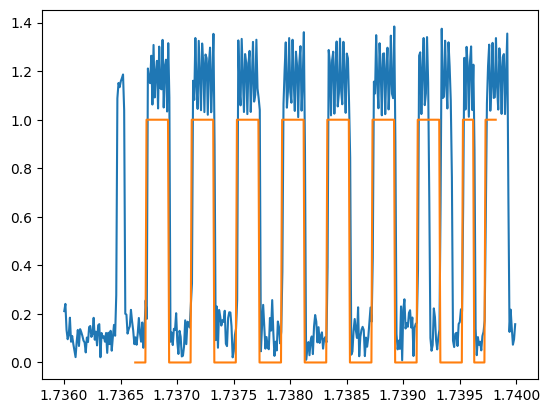

In [199]:
N = len(normalized)
t = np.linspace(0, N/Fs_y, N)
start = int(1.736*Fs_y)
end = int(1.740*Fs_y)
plt.plot(t[start:end], x5[start:end])
init = 0.956
lines = list(np.arange(20)*200e-6 + init)
# plt.vlines(x=lines, ymin=0, ymax=1, color='tab:orange')

preamble_expected = '1010101010101011'
def manchester_encoding(b_str):
    encoded_str = ''
    for b in b_str:
        if b == '0':
            encoded_str += '10'
        else:
            encoded_str += '01'
    return encoded_str

def create_waveform(b_str, baud_rate):
    T = 1/(2*baud_rate)
    
    y = np.zeros(10*len(b_str))
    t = np.arange(10*len(b_str)) * T/10
    for n, b in enumerate(b_str):
        if b == '1':
            y[10*n: 10*(n+1)] = 1

    return y, t

x = manchester_encoding(preamble_expected)
y1, t1 = create_waveform(x, 5000)
plt.plot(t1+1.73663, y1)

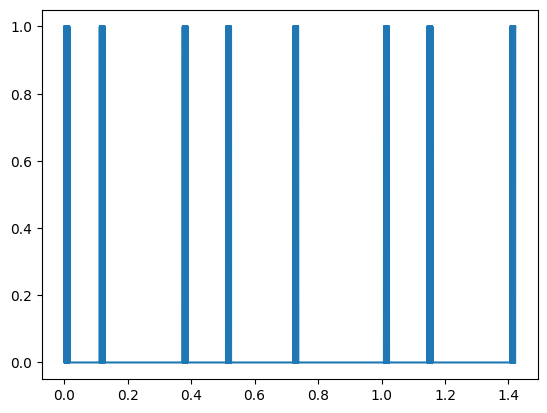

In [142]:
N1 = len(normalized_no_zeros)
t1 = np.linspace(0, N1/Fs_y, N1)
plt.plot(t1, normalized_no_zeros)

In [143]:
bin_str = ''.join(str(i) for i in normalized_no_zeros)

In [144]:
packets = []
for splitted in re.split('0{2000,}', bin_str):
    if (len(splitted) > 0):
        # make sure that we've got some zeroes at the end for regexp
        # splitted += "0" * 20
        # analyze and print
        packets.append(splitted)

In [145]:
test_str = packets[0]

In [146]:
from itertools import groupby
res = ["".join(group) for ele, group in groupby(test_str)]

In [147]:
lengths = [len(x) for x in res]
min_length = min(lengths)
max_length = max(lengths)

In [148]:
mid_length = (min_length + max_length)/2

In [149]:
mid_length

6.5

In [150]:
set(lengths)

{3, 4, 5, 6, 10}

In [151]:
res.insert(0, '0'*min_length)

In [37]:
output = ''
for elem in res:
    if len(elem) < mid_length:
        output += elem[0]
    else:
        output += elem[0]*2

In [38]:
output += '0'

In [39]:
pairs = [output[n:n+2] for n in range(0, len(output), 2)]

In [40]:
final_str = ''
for p in pairs:
    if p == '01':
        final_str += '1'
    elif p == '10':
        final_str += '0'

In [41]:
preamble = final_str[:16]
message_type = final_str[16:20]
transmitter_id = final_str[20:44]
transmitter_type = final_str[44:49]
status = final_str[49:60]
spare_bit_1 = final_str[60:61]
message_number = final_str[61:65]
spare_bit_2 = final_str[65:66]
packet_number = final_str[66:69]
crc = final_str[69:81]

In [152]:
preamble

'1000101111111100'

In [166]:
preamble_expected = '1010101010101011'

In [130]:
2/5000

0.0004

In [132]:
1/5000/2

0.0001

In [ ]:
1000101111111100
1010101010101011